# Visualization of cluster annotations

Perhaps a lot of this can be done in quPath?

Objectives:
- Create MERSCOPE boundary image for QuPath import
- examine cluster classifications in physical space
- create voronoi (or similar) representation of segmented cells
- Create polygon masks of Baysor segmentations for import to QuPath


In [1]:
import tifffile as tff
from cv2 import imwrite
import pandas as pd
import numpy as np
import seaborn as sns
# import pickle as pk
import matplotlib.pyplot as plt
import pickle as pk
from tqdm import tqdm
from imantics import Polygons, Mask
import geojson as gjson
from scipy.spatial import ConvexHull
import matplotlib.cm as cm

## Making the boundary image

In [2]:
b1 = tff.TiffFile('../data/mosaic_Cellbound1_z3.tif')
b1 = b1.asarray()/255
b1 = b1.astype(int)
np.max(b1)

184

In [3]:
b2 = tff.TiffFile('../data/mosaic_Cellbound2_z3.tif')
b2 = b2.asarray()/255
b2 = b2.astype(int)
b2.shape

(70573, 107613)

In [4]:
b3 = tff.TiffFile('../data/mosaic_Cellbound3_z3.tif')
b3 = b3.asarray()/255
b3 = b3.astype(int)
np.max(b3)

166

In [5]:
# concat image...
img_out = np.stack([b1, b2, b3], axis=0)
img_out.shape

(3, 70573, 107613)

In [42]:
# 55000:60000 , 45000:50000
# small_1 = 58000:62000, 48000:52000
# small_2 = 41000:46000, 72000:77000
img_small = img_out[:, 41000:46000, 72000:77000].copy()
# img_small = np.moveaxis(img_small,0,-1)
# img_small = np.flip(img_small, 0)
# for export:
img_small = np.flip(img_small, 1)
img_small *= 2

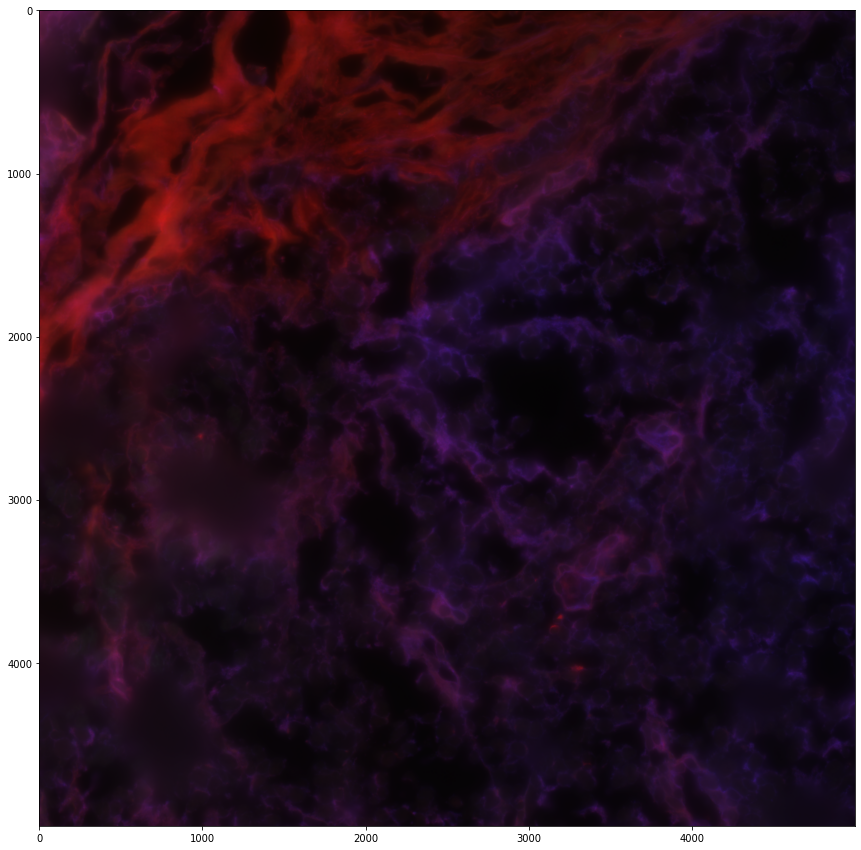

In [41]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img_small)
# plt.savefig('test.png', transparent=True, dpi=300, facecolor='white')

In [43]:
img_small = img_small/255

In [30]:
outname = 'input_merscope_small_2.qptiff'

In [31]:
xml = f"""<?xml version="1.0" encoding="UTF-8"?>
<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
     xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
     xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
    <Image ID="Image:0" Name="{outname}">
        <Pixels BigEndian="false"
                DimensionOrder="XYCZT"
                ID="Pixels:0"
                Interleaved="false"
                SizeC="{img_small.shape[0]}"
                SizeT="1"
                SizeX="{img_small.shape[2]}"
                SizeY="{img_small.shape[1]}"
                SizeZ="1"
                PhysicalSizeX="1.0"
                PhysicalSizeY="1.0"
                Type="float">
            <TiffData />
            </Pixels>
    </Image>
</OME>
"""

In [44]:
tff.imwrite(
    outname,
    data=img_small,
    photometric='minisblack',
    description=xml
    # tile=(256, 256),
    # resolution=(25400, 25400, "inch"),
    # compress=9,
    # metadata={'Channel': {'MarkerName': list(channel_names)}}
)

In [ ]:
# outname = 'input_merscope.qptiff'

In [ ]:
# xml = f"""<?xml version="1.0" encoding="UTF-8"?>
# <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
#      xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
#      xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
#     <Image ID="Image:0" Name="{outname}">
#         <Pixels BigEndian="false"
#                 DimensionOrder="XYCZT"
#                 ID="Pixels:0"
#                 Interleaved="false"
#                 SizeC="{img_out.shape[0]}"
#                 SizeT="1"
#                 SizeX="{img_out.shape[2]}"
#                 SizeY="{img_out.shape[1]}"
#                 SizeZ="1"
#                 PhysicalSizeX="1.0"
#                 PhysicalSizeY="1.0"
#                 Type="float">
#             <TiffData />
#             </Pixels>
#     </Image>
# </OME>
# """

In [ ]:
# tff.imwrite(
#     outname,
#     data=img_out,
#     photometric='minisblack',
#     description=xml,
#     # tile=(256, 256),
#     # resolution=(25400, 25400, "inch"),
#     compress=9,
#     # metadata={'Channel': {'MarkerName': list(channel_names)}}
# )

In [ ]:
with open('merscope_stack.pk', 'wb') as f:
    pk.dump(img_out, f)

## Masking the Baysor segmentations

adata obs x,y are transpose boundary image x,y

How do I find the region from above in the obs data??!

In [2]:
# trx = pd.read_csv("../02-Baysor/test/segment_m150_std50_s35_compweight02/segmentation.csv")
# trx = pd.read_csv("../03-clustering/tiled_segment_result.csv")
with open('tiled_segment_result_withNoise.pk', 'rb') as f:
    trx = pk.load(f)
# with open('tiled_segment_result.pk', 'rb') as f:
#     trx = pk.load(f)
trx.head()

Unnamed: 0  barcode_id   global_x   global_y    z  x_reserved  \
Column1                                                                  
4             13130           4  138.44290  3771.7260  0.0   1281.8787   
5             13612           4  121.31161  3712.9062  1.0   1123.2556   
9             17917           5  132.25273  3726.0737  1.0   1224.5624   
10            21284           6  175.36775  3759.7747  2.0   1623.7754   
11            21286           6  192.27090  3760.4000  2.0   1780.2861   

         y_reserved  fov    gene    transcript_id            x             y  \
Column1                                                                        
4         1587.3884    0   TBX21  ENST00000177694  1281.877835  34923.365226   
5         1042.7616    0   TBX21  ENST00000177694  1123.254887  34378.737817   
9         1164.6815    0  TGFBR3  ENST00000212355  1224.561485  34500.659031   
10        1476.7281    0  PCSK1N  ENST00000218230  1623.774363  34812.705116   
11        1482.5177    0  PCSK1N  ENST00000218230  1780.284905  34818.494927   

         molecule_id  confidence  cluster  cell  assignment_confidence  \
Column1                                                                  
4                  1         0.0        1   0.0                    1.0   
5                  2         0.0        1   0.0                    1.0   
9                  3         0.0        2   0.0                    1.0   
10                 4         0.0        3   0.0                    1.0   
11                 5         0.0        3   0.0                    1.0   

         is_noise ncv_color  
Column1                      
4            True   #007B6B  
5            True   #00A7FF  
9            True   #00DBFF  
10           True   #00746D  
11           True   #007B8B

In [32]:
# with open('adata_m150_s35_std50_obs.pk', 'rb') as f:
#     cells = pk.load(f)
# cells.head()
with open('Tiled_input/tiled_segment_M0_A2_obs_v2.pk', 'rb') as f:
    cells = pk.load(f)
cells.head()


cluster            x             y     global_x     global_y  n_genes  \
cell                                                                          
1.0         3  9814.177667  34514.342452  1059.931906  3727.551510       28   
2.0         3  9682.431879  34771.178573  1045.703352  3755.289830       39   
3.0         1  9885.160007  34576.806317  1067.598004  3734.297613       94   
4.0         2  9191.688652  35310.791135   992.703047  3813.568027       39   
5.0         3  9628.535631  34824.350603  1039.882553  3761.032413       75   

      n_genes_by_counts  total_counts leiden          cell_type  \
cell                                                              
1.0                  28          48.0      1  Adrenergic_cortex   
2.0                  39          66.0      1  Adrenergic_cortex   
3.0                  94         264.0      2         Adrenergic   
4.0                  39          64.0      1  Adrenergic_cortex   
5.0                  75         186.0      7         Adrenergic   

          cell_type_sub  
cell                     
1.0   Adrenergic_cortex  
2.0   Adrenergic_cortex  
3.0          Adrenergic  
4.0   Adrenergic_cortex  
5.0          Adrenergic

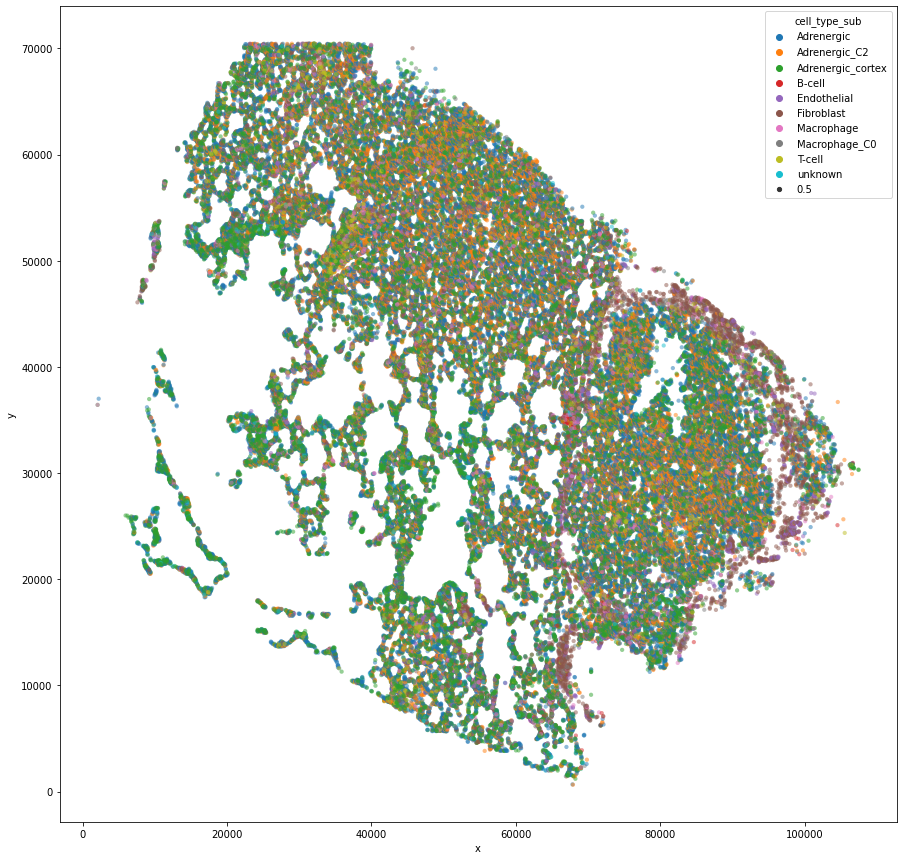

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=cells, x='x', y='y', hue='cell_type_sub', ax=ax, alpha=0.5, linewidth=0, size=0.5)
# plt.scatter(small['x'], -small['y'], c=small['cell_type'])
plt.savefig('plots/cell_type_sub_whole_tissue.pdf', dpi=300)
plt.show()

In [87]:
label_group = dict(zip(cells['cell_type_sub'].unique(), np.arange(1, cells['cell_type_sub'].nunique() + 1)))
label_group['noise'] = 0

In [ ]:
# this feels crazy that I need to reverse the label dictionary
# str(label_group_df.index[label_group_df.iloc[:,0]==3][0])
cmap=cm.tab20
cmaplist = [cmap(i) for i in range(len(label_group))]
ct_cmap = dict(zip(label_group.keys(), cmaplist))

In [35]:
# # view 1
xmin = 74000
xmax = 75000
ymin = 41500
ymax = 42500
# # view 1
# xmin = 72000
# xmax = 77000
# ymin = 41000
# ymax = 46000
# # view 2
# xmin = 49000
# xmax = 55000
# ymin = 55000
# ymax = 60000
# # view 3
# xmin = 45000
# xmax = 50000
# ymin = 57000
# ymax = 64000
# # view 4
# xmin = 70000
# xmax = 75000
# ymin = 14000
# ymax = 19000

In [36]:
small = cells[(cells['x'] > xmin) & (cells['x'] < xmax) & (cells['y'] > ymin) & (cells['y'] < ymax)].copy()
# in the case of param sweep testing:
# small = cells
# small.shape

In [86]:
# label_group = dict(zip(small['cell_type_sub'].unique(), np.arange(1, small['cell_type_sub'].nunique() + 1)))
# label_group['noise'] = 0

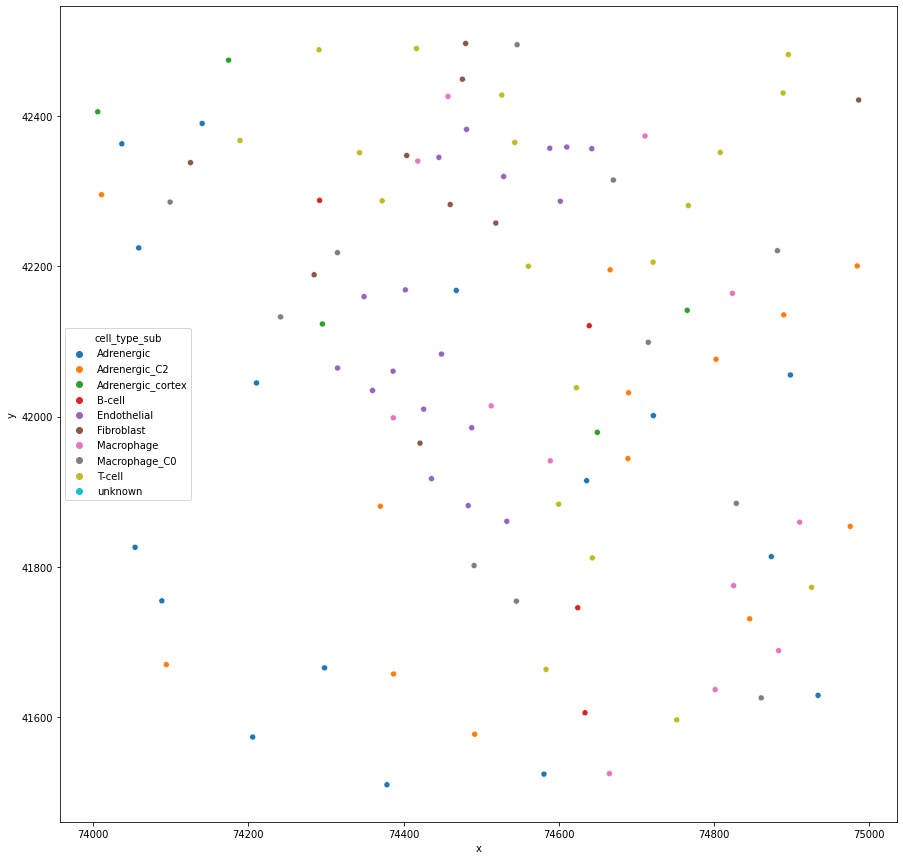

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=small, x='x', y='y', hue='cell_type_sub', ax=ax)
# plt.scatter(small['x'], -small['y'], c=small['cell_type'])
plt.show()

In [71]:
keep_cells = small.index.values
keep_cells = keep_cells.astype(float).astype(int)
keep_cells = np.append(keep_cells, 0)

In [72]:
keep_cells

array([190089, 190129, 190132, 190169, 190238, 190239, 190287, 190323,
       190355, 190389, 190425, 190427, 190439, 190457, 190465, 190492,
       190493, 190524, 190532, 190535, 190546, 190561, 190562, 190563,
       190570, 190576, 190577, 190582, 190585, 190588, 190595, 190603,
       190626, 190629, 190631, 190653, 190670, 190678, 190691, 190693,
       190702, 190714, 190727, 190728, 190734, 190742, 190747, 190752,
       190788, 190791, 190809, 190815, 190820, 190835, 190839, 190842,
       190854, 190870, 190875, 190878, 190900, 190908, 190912, 190919,
       190938, 190944, 190955, 190957, 190958, 190959, 190988, 190997,
       191005, 191021, 191023, 191025, 191040, 191050, 191080, 191083,
       191090, 191102, 191131, 191134, 191142, 191145, 191148, 191153,
       191157, 191206, 191211, 191232, 191285, 191337, 191422, 191482,
       191538, 195653, 195750, 196035, 197062, 197528, 198091, 198598,
       198712, 198848, 199367,      0])

In [59]:
190129. in keep_cells

False

In [97]:
ct_dict = dict(zip(keep_cells, small['cell_type_sub']))
# label_dict = dict(zip(keep_cells, small['leiden']))
ct_dict[0] = 'noise'

In [73]:
# trx_small = trx_small[(trx_small['x'] > xmin) & (trx_small['x'] < xmax) & (trx_small['y'] > ymin) & (trx_small['y'] < ymax)]
trx_small = trx.loc[(trx['x'] > xmin) & (trx['x'] < xmax) & (trx['y'] > ymin) & (trx['y'] < ymax)]
trx_small['cell'] = trx_small['cell'].astype(int)
trx_small.shape

/tmp/ipykernel_3736091/258559412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trx_small['cell'] = trx_small['cell'].astype(int)


(31614, 19)

In [75]:
trx_small['cell'].unique()

array([190577, 196315, 190425, 190129, 190457, 190570, 190169, 190678,
       190660, 190702, 199402, 190492, 190089, 200799, 190349, 190132,
       190131, 190813, 198598, 190815, 190809, 200800, 190493, 190532,
       190631, 190653, 191040, 190734, 190912, 190878, 191102, 191090,
       191083, 190524, 190595, 190957, 190900, 190727, 190944, 191145,
       191134, 191285, 191142, 190389, 190629, 190563, 190919, 191206,
       190439, 190535, 191444, 190908, 191232, 190742, 190465, 190670,
       190561, 199630, 191211, 191023, 199952, 198089, 190626, 197062,
       191348, 198091, 191005, 190955, 191131, 190839, 190842, 191422,
       190791, 190988, 190585, 190427, 190691, 190582, 191153, 198712,
       190693, 190562, 190323, 191050, 190714, 191337, 199367, 190747,
       190546, 191044, 191157, 198600, 191482, 191584, 191021, 190997,
       190875, 191084, 190576, 196055, 190588, 190788, 197028, 195653,
       190603, 190959, 198484, 191538, 191025, 200359, 190854, 197794,
      

In [76]:
trx_small = trx_small.loc[trx_small['cell'].isin(keep_cells), :].copy()
trx_small.shape

(29781, 19)

In [77]:
trx_small['cell_type'] = trx_small['cell'].apply(lambda x: ct_dict[x])
# trx_small['leiden'] = trx_small['cell'].apply(lambda x: label_dict[x])

In [15]:
# flip the y
# trx_small['inv_y'] = abs(trx_small['y']-70573)

In [82]:
trx_small['cell_int'] = trx_small['cell_type'].apply(lambda x: label_group[x])
# label_group = dict(zip(trx_small['leiden'].unique(), np.arange(1, trx_small['leiden'].nunique() + 1)))
# trx_small['cell_int'] = trx_small['leiden'].apply(lambda x: label_group[x])

In [95]:
trx_small['cell_int'].value_counts()

0    6516
1    5196
2    3732
5    3594
7    2919
4    2814
3    2064
6    1352
8    1302
9     292
Name: cell_int, dtype: int64

In [145]:
len(label_dict)

108

/mnt/isilon/cscb/software/anaconda3/envs/imageAnalysis/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


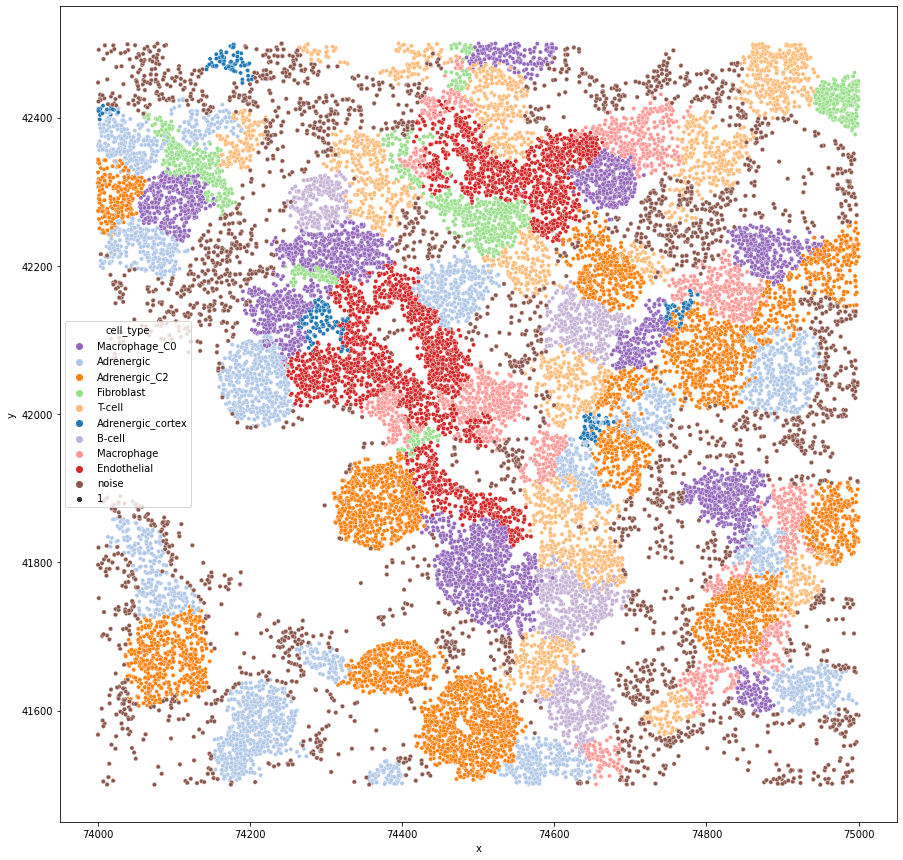

In [151]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(trx_small['x'], trx_small['y'], size=1, ax=ax, palette=ct_cmap, hue=trx_small['cell_type'])
plt.savefig('outs/test.png')

/mnt/isilon/cscb/software/anaconda3/envs/imageAnalysis/lib/python3.10/site-packages/matplotlib/collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


AttributeError: 'PathCollection' object has no attribute 'legend'

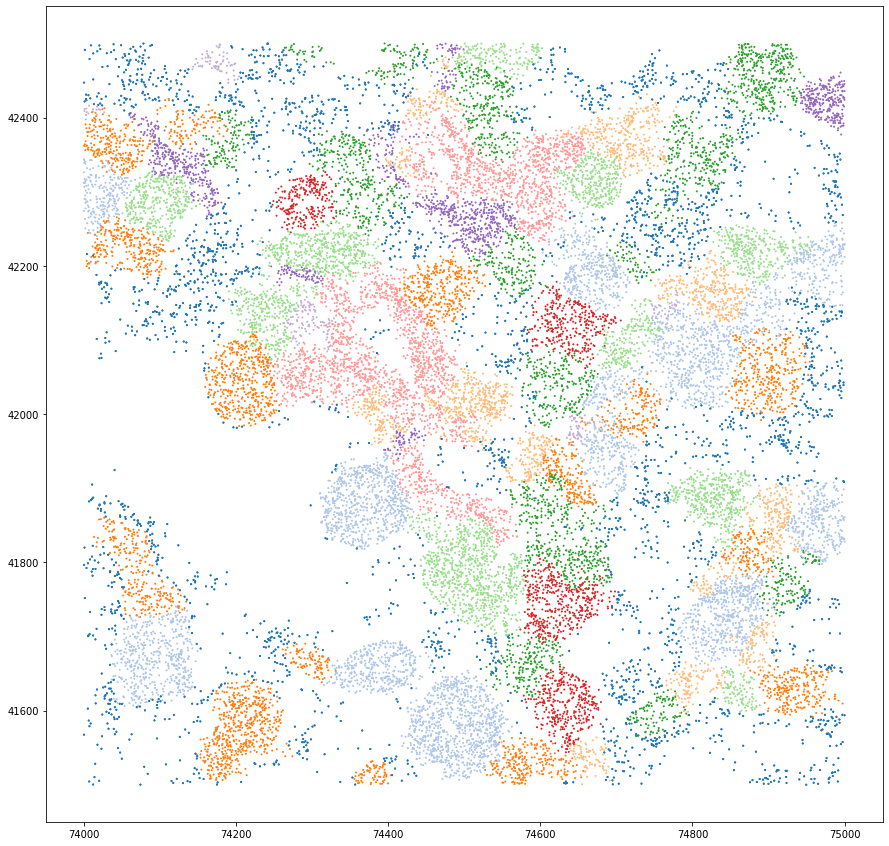

In [137]:
fig, ax = plt.subplots(figsize=(15, 15))
# scatter = ax.scatter(trx_small['x'], trx_small['y'], s=1, c=trx_small['cell_int'], cmap=cm.tab20)
scatter = ax.scatter(trx_small['x'], trx_small['y'], s=1, c=cm.tab20(trx_small['cell_int']), label=trx_small['cell_int'])
# ax.legend(*scatter.legend_elements(), loc=3)
h = scatter.legend_elements()[0]
# ax.legend(h, list(trx_small['cell_type'].unique()), loc=3)
# ax.legend(h, list(trx_small['cell_type'].unique()), loc=3)
# legend_key = list(map(lambda x: str(label_group_df.index[label_group_df.iloc[:,0]==x][0]), trx_small['cell_int'].value_counts().index))
# ax.legend(h, legend_key, loc=3)
scatter.legend(h, list(label_dict.keys()), loc='r')
# fig.colorbar(cm.ScalarMappable(cmap=cm.tab20((0,1,2,3))), ax=ax, loc='r')
# plt.savefig('plots/example2_MERSCOPE_only.pdf', dpi=300)
# plt.savefig('plots/view1_MERSCOPE_cell_type_sub_withNoise.png', dpi=300)
plt.show()

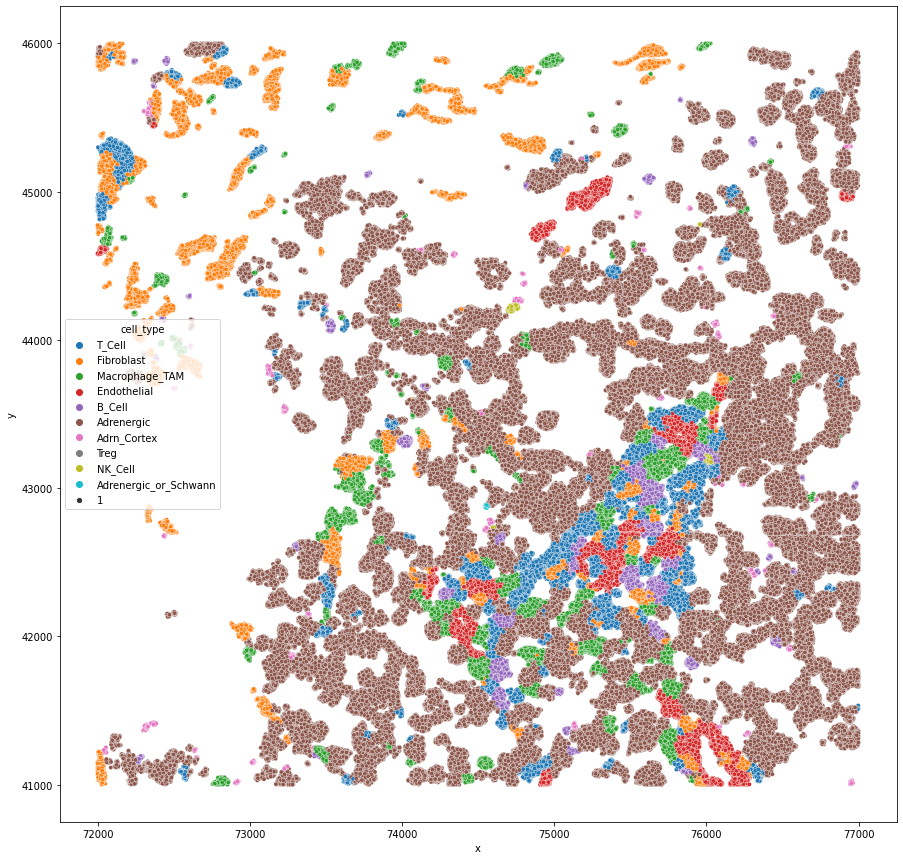

In [72]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=trx_small, x='x', y='y', hue='cell_type', size=1, ax=ax)
# plt.scatter(small['x'], -small['y'], c=small['cell_type'])
plt.show()

### Trying to make a cell type mask

Need to reset the coordinates to 0,0 origin

In [7]:
# in the case param sweep testing
trx_small = trx

In [8]:
# dim = [trx_small['y'].max() - trx_small['y'].min(), trx_small['x'].max() - trx_small['x'].min()]
# dim = tuple(map(int, dim))
mask = np.zeros((5000,5000))

In [9]:
# change trx coordinates to match mask
trx_small['new_x'] = trx_small['x'].apply(lambda x: int(np.floor(x - xmin)))
trx_small['new_y'] = trx_small['y'].apply(lambda x: int(np.floor(x - ymin)))

In [72]:
# mask_values = list(map(lambda x: label_group[x], trx_small['cell_type']))

KeyError: 64492

In [10]:
# mask[trx_small['new_y']-1, trx_small['new_x']-1] = mask_values
mask[trx_small['new_y'], trx_small['new_x']] = trx_small['cell']

In [11]:
mask = np.flip(mask, 0).T
# mask = mask.T

In [58]:
np.unique(mask)[50:60]

array([80080., 80093., 80135., 80140., 80186., 80195., 80219., 80220.,
       80238., 80322.])

In [13]:
len(np.unique(mask))

1510

In [15]:
# make a convex hull for each cell
features = []
for i in tqdm(np.unique(mask)):
    if i == 0:
        continue
    if np.sum(mask==i) < 10:
        continue
    poly = ConvexHull(list(zip(*np.where(mask==i))))
    polyPoints = poly.points[poly.vertices]
    if polyPoints.shape[0] < 4:
        continue
    polyPoints = np.vstack([polyPoints, polyPoints[0]])
    features.append(gjson.Feature(id="PathDetectionObject",
                                  # geometry=gjson.Polygon(np.expand_dims(polyPoints, axis=0).tolist()), 
                                  geometry=gjson.Polygon(np.expand_dims(polyPoints, axis=0).tolist()), 
                                  properties={"isLocked": True, 
                                              "measurements": [],
                                              "classification": {
                                                  "name": label_dict[i]
                                              }}))

100%|██████████| 2035/2035 [13:39<00:00,  2.48it/s]


In [16]:
with open('m150_s35_std50_detections.geojson', 'w') as f:
    gjson.dump(features, f)

In [62]:
img_small.shape

(3, 5000, 5000)

In [63]:
mask.shape

(5160, 5136)